
---
title: "Time series with varying intercepts"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

I've done time-series data with time-to-event models and would like to explore modeling with mixed effects models. I'll take an interative approach, in the spirit of [Singer and Willet's Applied Longitudinal Data Analysis: Modeling Change and Event Occurrence](https://academic.oup.com/book/41753?login=false). I discovered this textbook when finding this [post by Nathaniel Forde](https://www.pymc.io/projects/examples/en/latest/time_series/longitudinal_models.html) on the pymc website.

In this post, we'll focus on varying intercepts, first from a Bayesian approach using pymc, followed by an example with statsmodels. In later posts, we'll increase the complexity such as incorporation of varying slopes.


In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [2]:
sns.set_context("talk")
sns.set_palette("colorblind")

In [3]:
def draw_causal_graph(
    edge_list, node_props=None, edge_props=None, graph_direction="UD"
):
    """Utility to draw a causal (directed) graph
    Taken from: https://github.com/dustinstansbury/statistical-rethinking-2023/blob/a0f4f2d15a06b33355cf3065597dcb43ef829991/utils.py#L52-L66

    """
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

# Data generation

In [4]:
# Generate a very small synthetic data (assisted by ChatGPT)
n_patients = 15
n_timepoints = 5

# Create patient IDs
patient_ids = np.repeat(np.arange(n_patients), n_timepoints)

# Create time points
time = np.tile(np.arange(n_timepoints), n_patients)

# Create patient-specific attributes (age and treatment)
age = np.random.randint(40, 70, n_patients)
treatment = np.random.binomial(1, 0.5, n_patients)

# Repeat age and treatment to match the longitudinal measurements
age_repeated = np.repeat(age, n_timepoints)
treatment_repeated = np.repeat(treatment, n_timepoints)

# Combine into a DataFrame
df_data = pd.DataFrame(
    {
        "patient_id": patient_ids,
        "time": time,
        "age": age_repeated,
        "treatment": treatment_repeated,
    }
)

df_data.head(10)

,patient_id,time,age,treatment
0,0,0,49,0
1,0,1,49,0
2,0,2,49,0
3,0,3,49,0
4,0,4,49,0
5,1,0,45,1
6,1,1,45,1
7,1,2,45,1
8,1,3,45,1
9,1,4,45,1


Here's the fun part. We'll simulate the outcome variable tumor size, using some mild assumptions and domain knowledge. First, we'll assume that all participants have been identified as having a solid tumor cancer. Therefore:

- Time is also a positive association risk factor.
- Age is likely a risk factor, so create a positive association between age and tumor size. (Note that we'll keep age as a constant for each patient, such that we're looking at a time window of a few months.)
- Whether one has received treatment should decrease the tumor size, so that will be a negative association.

This will be a simple linear model that we'll use to create data:

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha + \beta_T T_i + \beta_A A_i + \beta_R R_i $$



In [5]:
# Use a generative model to create tumor size with some randomness

alpha_tumor_size = 50  # intercept term
bT = 1  # positive association for time
bA = 0.25  # positive association for age
bR = -5  # negative association for treatment

mu_tumor_size = (
    alpha_tumor_size
    + bT * df_data["time"]
    + bA * df_data["age"]
    + bR * df_data["treatment"]
)

sigma_tumor_size = 2

df_data["tumor_size"] = np.random.normal(mu_tumor_size, sigma_tumor_size)

df_data.head()

,patient_id,time,age,treatment,tumor_size
0,0,0,49,0,60.902427
1,0,1,49,0,65.889482
2,0,2,49,0,64.926485
3,0,3,49,0,63.643611
4,0,4,49,0,65.586947


# Data transformation

Before doing any modeling, we'll transform the data since in theory we shouldn't peek. But we can't pick priors unless we have some idea of what the data is like. An easy thing to do is standardize the data and therefore we can use a 0 mean, 2 SD prior to capture most of the data.

In [6]:
df_data["tumor_size_std"] = standardize(df_data["tumor_size"])

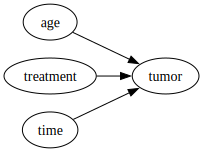

In [7]:
# how to represent patient_specific random effect?
draw_causal_graph(
    edge_list=[("age", "tumor"), ("treatment", "tumor"), ("time", "tumor")],
    graph_direction="LR",
)

In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_id      75 non-null     int64  
 1   time            75 non-null     int64  
 2   age             75 non-null     int64  
 3   treatment       75 non-null     int64  
 4   tumor_size      75 non-null     float64
 5   tumor_size_std  75 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 3.6 KB


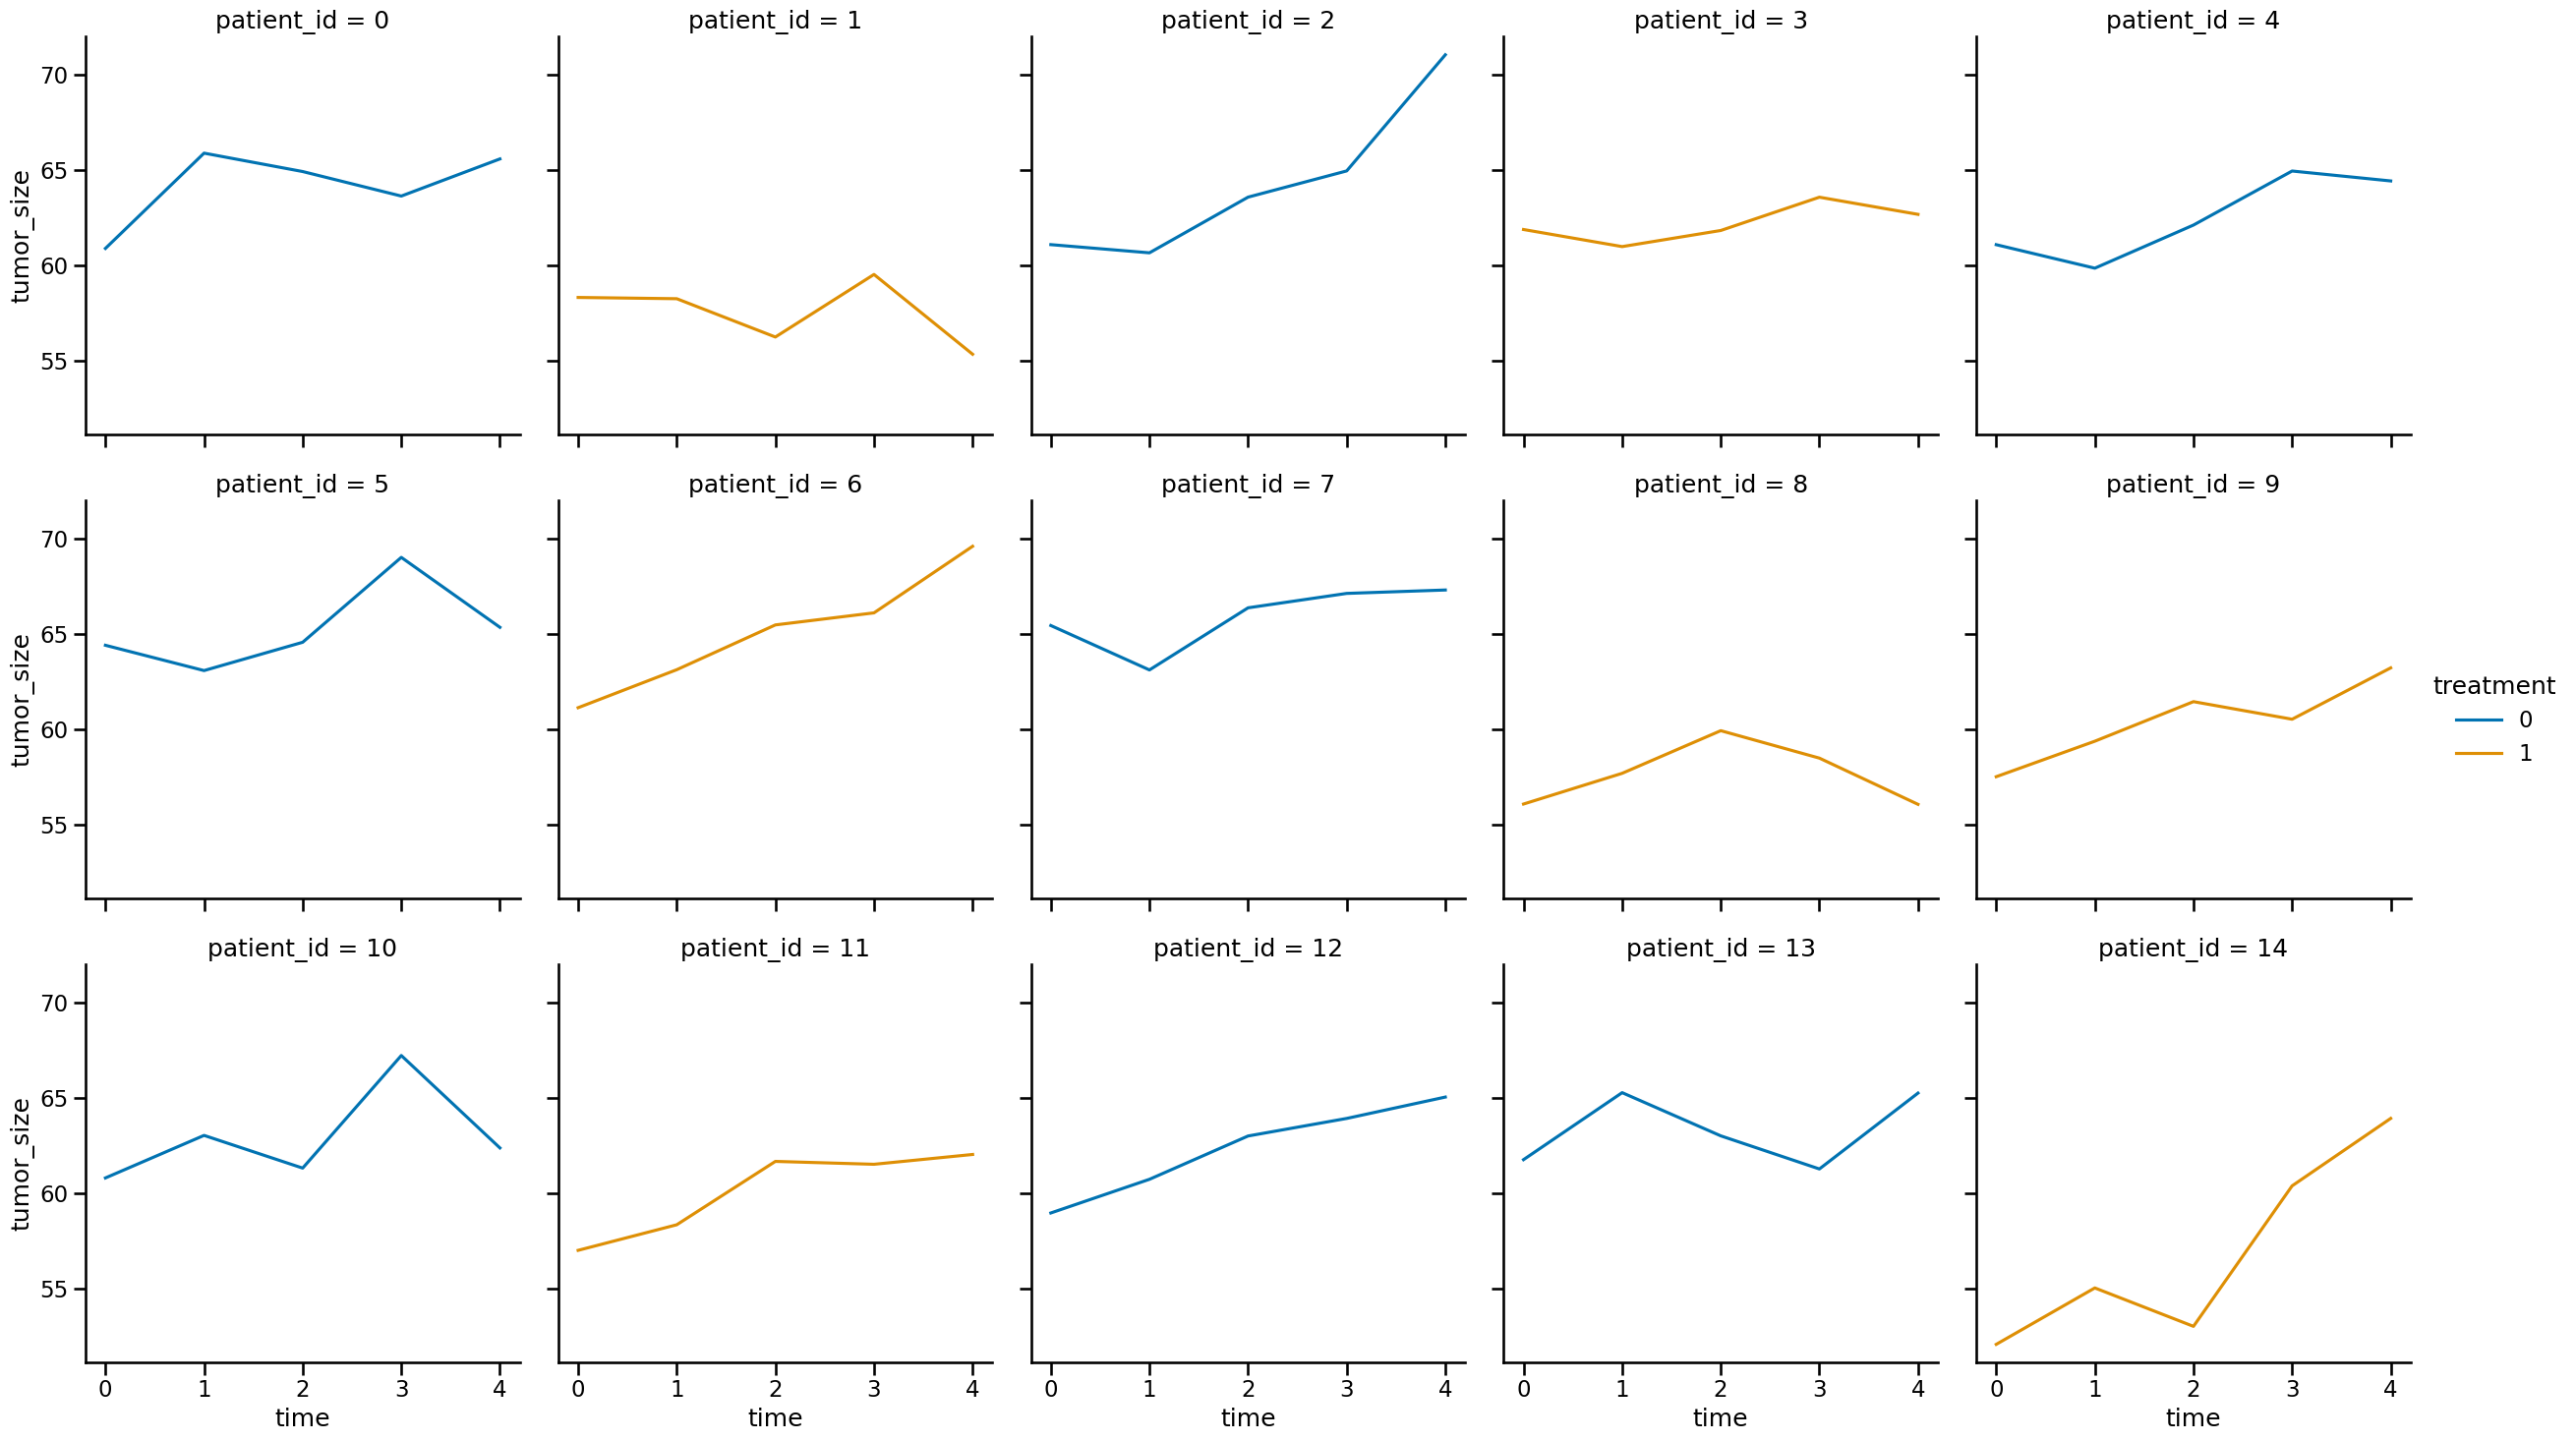

In [9]:
sns.relplot(
    data=df_data,
    x="time",
    y="tumor_size",
    col="patient_id",
    col_wrap=5,
    hue="treatment",
    kind="line",
)

Text(0.5, 1.0, 'Effect of Treatment on tumor size')

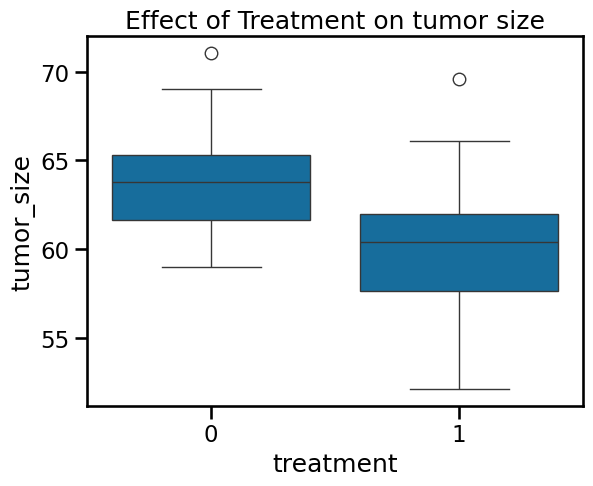

In [10]:
ax = sns.boxplot(
    data=df_data,
    x="treatment",
    y="tumor_size",
)
ax.set_title("Effect of Treatment on tumor size")

# Varying intercepts using pymc

Let's define the equation. We're going to assume the tumor size is Gaussian distributed.

It will be a linear combination of independent variables for time, age, and treatment. How will we represent the `patient_id`? 

There will be a term for average tumor size and the patient-specific tumor size will be the "random effect".

s = tumor size
t = time
a = age
r = treatment

After reading McElreath, for now, I will ignore time, age, and treatment and just think of patient as a cluster.

$$ \mu_i = \alpha_{\text{pt[i]}} + \beta_T T_i + \beta_A A_i + \beta_R R_i  \tag{save for later}$$
$$ \beta_T, \beta_A, \beta_R \sim \text{Normal}(0, 1) \tag{save for later} $$


Let's do this step-by-step and work our way from the most naive, simplest models to more complex and informative.

0. **Complete pooling, intercepts only.** Ignore patients as clusters.
1. **No pooling, intercepts only**. Keep intercepts separate for each patient. Ignore information across patients.
2. **Partial pooling, intercepts only.** Share information across patients.

## Model 0. Complete pooling.

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha  $$

$$ \alpha \sim \text{Normal}(0, 1) $$

$$ \sigma \sim \text{Exponential}(1) $$

The `patient_id` variable is completely ignored. A subscript to denote the patient is not relevant here?

In [11]:
# complete pooling, intercepts only
with pm.Model() as m0:

    # priors
    a = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)

    # linear model
    mu = a

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m0 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma]


Output()

In [12]:
az.summary(trace_m0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.001,0.120,-0.235,0.216,0.002,0.002,4160.0,3166.0,1.0
sigma,1.017,0.087,0.848,1.169,0.001,0.001,3949.0,2692.0,1.0


<Axes: >

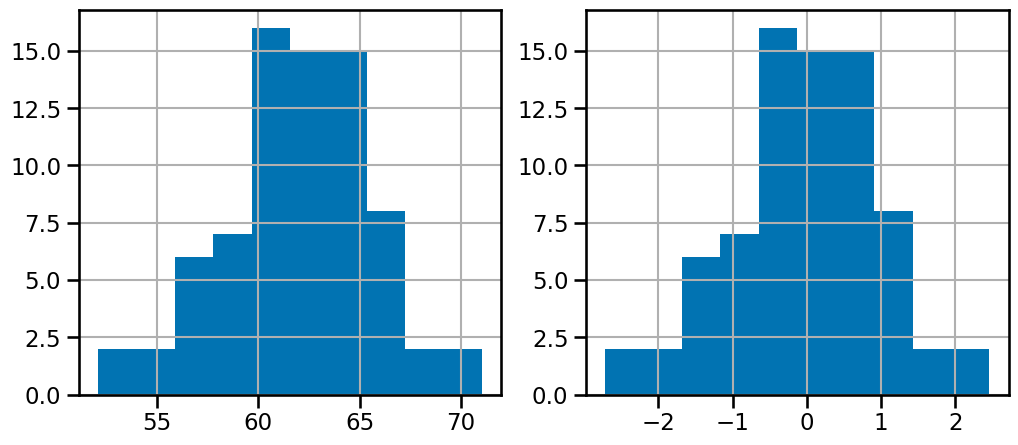

In [13]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))  # do add subplots
df_data["tumor_size"].hist(ax=ax0)
df_data["tumor_size_std"].hist(ax=ax1)

## Model 2. No pooling.
Acknowledge that there are patient clusters but do not share any information across them. In other words have a prior but no adaptive regularization.

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha_{\text{pt[i]}}  $$

$$ \alpha_j \sim \text{Normal}(0, 1) $$

$$ \sigma \sim \text{Exponential}(1) $$

In [14]:
# no pooling, intercepts only
with pm.Model() as m1:

    # priors
    a = pm.Normal("a", 0.0, 1, shape=df_data["patient_id"].nunique())
    sigma = pm.Exponential("sigma", 1.0)

    # linear model... # initialize with pymc data?... represent patient as its own cluster
    mu = a[df_data["patient_id"]]

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m1 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma]


Output()

In [15]:
az.summary(trace_m1).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.533,0.305,-0.059,1.090,0.003,0.003,8071.0,2838.0,1.00
a[1],-1.112,0.306,-1.675,-0.522,0.003,0.003,7748.0,2532.0,1.00
a[2],0.551,0.306,-0.051,1.087,0.003,0.003,8794.0,3121.0,1.00
a[3],0.036,0.309,-0.611,0.561,0.003,0.005,8182.0,3026.0,1.00
a[4],0.112,0.303,-0.471,0.684,0.003,0.005,8928.0,2725.0,1.01


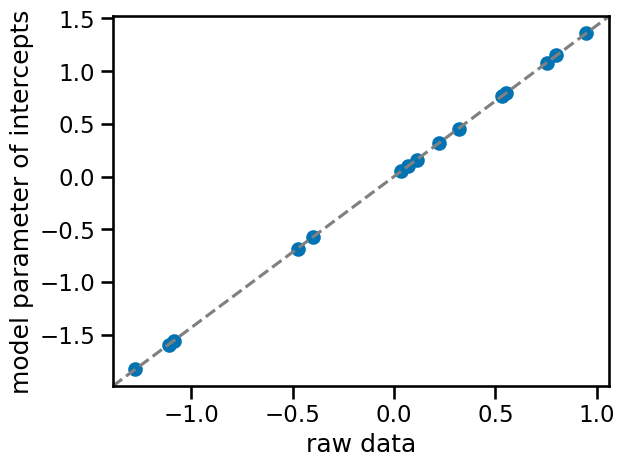

In [16]:
f, ax = plt.subplots()
ax.scatter(
    az.summary(trace_m1, var_names=["a"])["mean"],
    standardize(df_data.groupby("patient_id")["tumor_size"].mean()),
)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="dashed", color="gray")
ax.set(xlabel="raw data", ylabel="model parameter of intercepts");

## Model 2. Use random intercepts.

$$ s_i \sim \text{Normal}(\mu_i, \sigma) $$

$$ \mu_i = \alpha_{\text{pt[i]}}  $$

$$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\text{pt}}) $$

$$ \bar{\alpha} \sim \text{Normal}(0, 1) $$



$$ \sigma_{\text{pt}} \sim \text{Exponential}(1) $$

$$ \sigma \sim \text{Exponential}(1) $$

**Question**
- can sigma parameter be partially pooled?

In [17]:
# multilevel model, random intercepts
with pm.Model() as m2:

    # prior for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)

    # prior for SD of patients
    sigma_pt = pm.Exponential("sigma_pt", 1.0)

    # alpha priors for each patient
    a = pm.Normal("a", a_bar, sigma_pt, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data["patient_id"]]

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m2 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, sigma_pt, a]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [18]:
az.summary(trace_m2, var_names=["a"]).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.485,0.303,-0.057,1.078,0.003,0.003,8342.0,3057.0,1.0
a[1],-1.019,0.307,-1.603,-0.451,0.004,0.003,6798.0,2573.0,1.0
a[2],0.506,0.302,-0.058,1.080,0.004,0.003,7416.0,3017.0,1.0
a[3],0.037,0.299,-0.521,0.588,0.003,0.005,8797.0,2897.0,1.0
a[4],0.103,0.296,-0.444,0.693,0.003,0.005,8112.0,3038.0,1.0


In [19]:
az.summary(trace_m2, var_names=["a_bar", "sigma"]).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.002,0.213,-0.386,0.419,0.003,0.003,5870.0,3262.0,1.0
sigma,0.726,0.067,0.605,0.847,0.001,0.001,4789.0,2968.0,1.0


## Comparison of estimates with no pooling, partial pooling


While there isn't an appreciable difference, the multilevel model has a lower standard deviation for each cluster. This is the partial pooling effect.

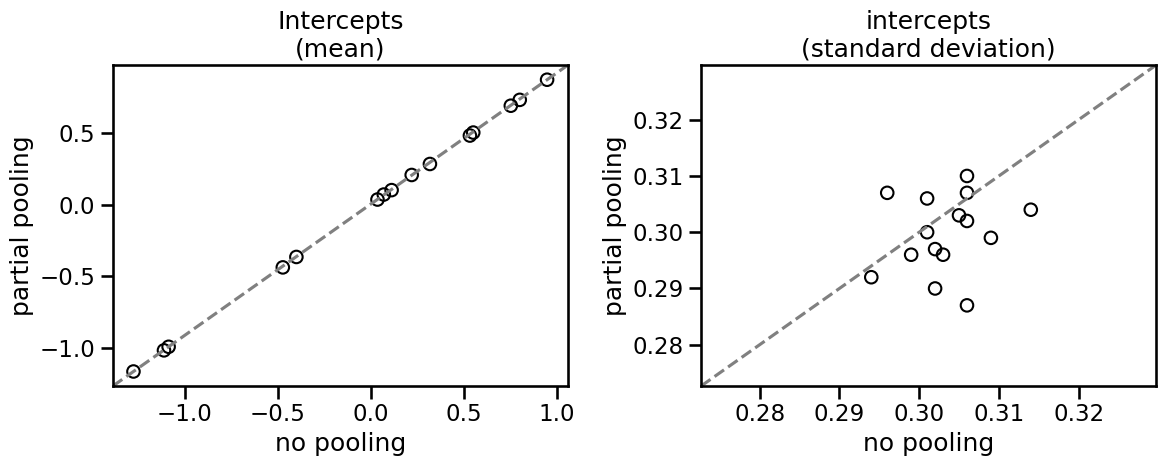

In [20]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# means
ax0.scatter(
    az.summary(trace_m1, var_names=["a"])["mean"],
    az.summary(trace_m2, var_names=["a"])["mean"],
    facecolors="none",
    edgecolors="k",
)
ax0.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
ax0.set(
    xlabel="no pooling",
    ylabel="partial pooling",
    title="Intercepts\n(mean)",
)

# SD
ax1.scatter(
    az.summary(trace_m1, var_names=["a"])["sd"],
    az.summary(trace_m2, var_names=["a"])["sd"],
    facecolors="none",
    edgecolors="k",
)
ax1.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
ax1.set(
    xlabel="no pooling",
    ylabel="partial pooling",
    title="intercepts\n(standard deviation)",
)
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linestyle="dashed", color="gray")

# Calculate the minimum and maximum of both x and y data
data_min = min(
    min(az.summary(trace_m1, var_names=["a"])["sd"]),
    min(az.summary(trace_m2, var_names=["a"])["sd"]),
)
data_max = max(
    max(az.summary(trace_m1, var_names=["a"])["sd"]),
    max(az.summary(trace_m2, var_names=["a"])["sd"]),
)

# Set the limits to be the same for both axes
ax1.set_xlim(data_min * 0.95, data_max * 1.05)
ax1.set_ylim(data_min * 0.95, data_max * 1.05)

f.tight_layout()

# Using statsmodels

In [153]:
# Define the mixed-effects model formula
# https://www.statsmodels.org/dev/_modules/statsmodels/regression/mixed_linear_model.html#MixedLM
# https://www.statsmodels.org/stable/generated/statsmodels.formula.api.mixedlm.html
model = smf.mixedlm(
    "tumor_size_std ~ time + age + treatment",
    df_data,
    groups=df_data["patient_id"],
    re_formula="~time",  #  A one-sided formula defining the variance structure of the model.  The default gives a random intercept for each group.
    # re_formula="~patient_id",
)

# Fit the model
result = model.fit()

# Print the summary of the model
result.summary()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: tumor_size_std
No. Observations: 50      Method:             REML          
No. Groups:       10      Scale:              0.2752        
Min. group size:  5       Log-Likelihood:     -48.0325      
Max. group size:  5       Converged:          No            
Mean group size:  5.0                                       
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         -3.485    0.662 -5.266 0.000 -4.782 -2.188
time               0.262    0.064  4.097 0.000  0.137  0.388
age                0.060    0.011  5.438 0.000  0.038  0.082
treatment         -1.192    0.201 -5.928 0.000 -1.586 -0.798
Group Var          0.159    0.480                           
Group x time Cov  -0.046    0.177                           
time Var           0.013    0.076                           
============================================================

"""

## Varying intercept model

In [154]:
# Define the mixed-effects model formula with only varying intercepts
model = smf.mixedlm("tumor_size_std ~ 1", df_data, groups=df_data["patient_id"])

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tumor_size_std
No. Observations: 50      Method:             REML          
No. Groups:       10      Scale:              0.4878        
Min. group size:  5       Log-Likelihood:     -62.6166      
Max. group size:  5       Converged:          Yes           
Mean group size:  5.0                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -0.000     0.260  -0.000  1.000  -0.510   0.510
Group Var      0.580     0.506                               



# Varying effects: models with slopes

## Model 4. No pooling, with slope for treatment.

In [167]:
df_data.head()

,patient_id,time,age,treatment,tumor_size,tumor_size_std
0,0,0,50,0,66.596144,0.602119
1,0,1,50,0,60.361651,-0.917804
2,0,2,50,0,64.371221,0.059699
3,0,3,50,0,68.276128,1.011686
4,0,4,50,0,63.329732,-0.194208


In [168]:
df_data.groupby(["treatment"])["tumor_size_std"].mean()

treatment
0    0.480397
1   -0.720595
Name: tumor_size_std, dtype: float64

In [169]:
# no pooling model
with pm.Model() as m4:

    # prior for sigma
    sigma = pm.Exponential("sigma", 1.0)

    # alpha, beta priors for each patient, set to numerical value and not pool
    a = pm.Normal("a", 0, 2, shape=len(df_data["patient_id"].unique()))
    bR = pm.Normal("bR", 0, 2, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data["patient_id"]] + bR[df_data["patient_id"]]

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m4 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:44

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.


In [170]:
az.summary(trace_m4, var_names=["a"]).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bR[0],0.082,1.423,-2.481,2.883,0.024,0.023,3433.0,2599.0,1.0
bR[1],0.631,1.464,-2.205,3.243,0.025,0.023,3333.0,2685.0,1.0
bR[2],-0.516,1.419,-3.205,2.052,0.024,0.022,3662.0,2647.0,1.0
bR[3],0.096,1.424,-2.606,2.710,0.024,0.024,3404.0,2409.0,1.0
bR[4],-0.003,1.400,-2.552,2.725,0.022,0.022,3993.0,2919.0,1.0


## Model 5. Multilevel model, with slope for treatment.

In [171]:
# multilevel model
with pm.Model() as m5:

    # hyperparameters, priors for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    bR_bar = pm.Normal("bR_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)

    # prior for SD of patients
    sigma_alpha = pm.Exponential("sigma_alpha", 1.0)
    sigma_bR = pm.Exponential("sigma_bR", 1.0)

    # alpha priors for each patient
    a = pm.Normal("a", a_bar, sigma_alpha, shape=len(df_data["patient_id"].unique()))

    # priors for beta for each patient
    bR = pm.Normal("bR", bR_bar, sigma_bR, shape=len(df_data["patient_id"].unique()))

    # linear model
    mu = a[df_data["patient_id"]] + bR[df_data["patient_id"]]

    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_m5 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Sampling 4 chains, 500 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:47

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [172]:
az.summary(trace_m5, var_names=["a_bar", "bR_bar", "sigma"]).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.180,0.751,-1.267,1.353,0.108,0.077,54.0,555.0,1.07
bR_bar,-0.168,0.728,-1.274,1.297,0.087,0.062,85.0,551.0,1.05
sigma,0.679,0.074,0.538,0.814,0.002,0.002,1121.0,1604.0,1.02


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

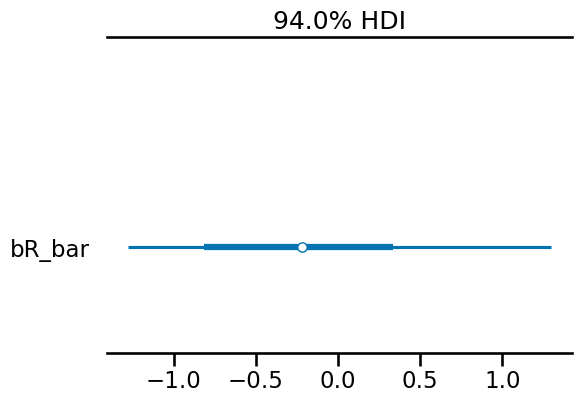

In [180]:
az.plot_forest(trace_m5, var_names="bR_bar", combined=True)

In [173]:
az.summary(trace_m5, var_names=["a"]).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bR[0],-0.126,0.817,-1.471,1.481,0.093,0.066,93.0,890.0,1.05
bR[1],0.378,0.971,-1.282,2.060,0.184,0.132,32.0,246.0,1.09
bR[2],-0.567,0.830,-2.142,1.007,0.043,0.030,372.0,750.0,1.04
bR[3],-0.090,0.833,-1.381,1.522,0.104,0.074,72.0,986.0,1.06
bR[4],-0.168,0.815,-1.578,1.401,0.092,0.065,93.0,726.0,1.05


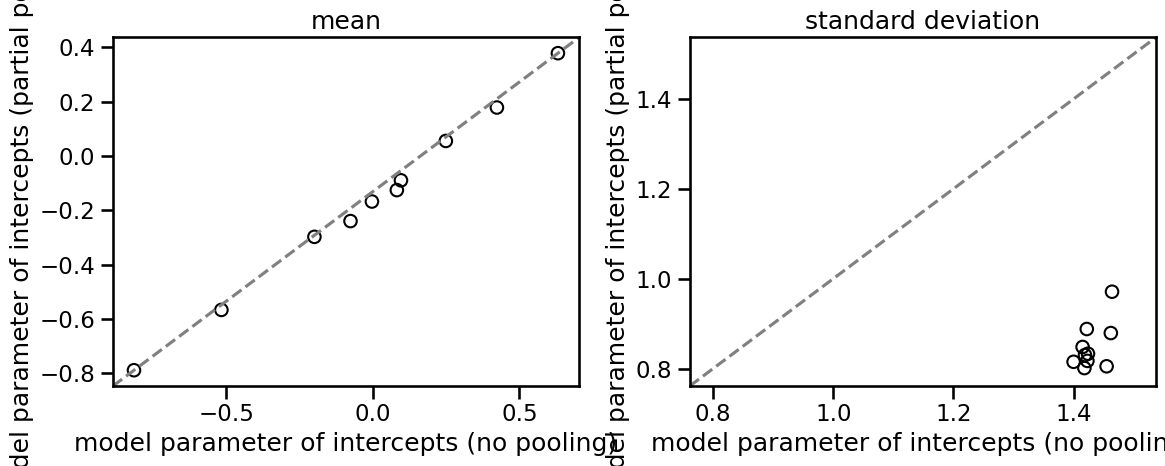

In [177]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

# means
ax0.scatter(
    az.summary(trace_m4, var_names=["a"])["mean"],
    az.summary(trace_m5, var_names=["a"])["mean"],
    facecolors="none",
    edgecolors="k",
)
ax0.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
ax0.set(
    xlabel="model parameter of intercepts (no pooling)",
    ylabel="model parameter of intercepts (partial pooling)",
    title="mean",
)

# SD
ax1.scatter(
    az.summary(trace_m4, var_names=["a"])["sd"],
    az.summary(trace_m5, var_names=["a"])["sd"],
    facecolors="none",
    edgecolors="k",
)
ax1.plot([0, 1], [0, 1], transform=ax0.transAxes, linestyle="dashed", color="gray")
ax1.set(
    xlabel="model parameter of intercepts (no pooling)",
    ylabel="model parameter of intercepts (partial pooling)",
    title="standard deviation",
)
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linestyle="dashed", color="gray")

# Calculate the minimum and maximum of both x and y data
data_min = min(
    min(az.summary(trace_m4, var_names=["a"])["sd"]),
    min(az.summary(trace_m5, var_names=["a"])["sd"]),
)
data_max = max(
    max(az.summary(trace_m4, var_names=["a"])["sd"]),
    max(az.summary(trace_m5, var_names=["a"])["sd"]),
)

# Set the limits to be the same for both axes
ax1.set_xlim(data_min * 0.95, data_max * 1.05)
ax1.set_ylim(data_min * 0.95, data_max * 1.05)

f.tight_layout()

# MODEL WITH SLOPES

In [10]:
# multilevel model
with pm.Model() as m3:

    # prior for average patient
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1.0)
    
    # prior for SD of patients
    sigma_pt = pm.Exponential("sigma_pt", 1.0)

    # alpha priors for each patient
    a = pm.Normal("a", a_bar, sigma_pt, shape=len(df_data["patient_id"].unique()))

    # priors for betas
    bT = pm.Normal("bT", 0, 1)
    bA = pm.Normal("bA", 0, 1)
    bR = pm.Normal("bR", 0, 1)

    # linear model
    mu = a[df_data['patient_id']
 
    # likelihood
    s = pm.Normal("s", mu=mu, sigma=sigma, observed=df_data["tumor_size_std"])

    trace_mme = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, sigma_pt, a, bT, bA, bR]


/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
az.summary(trace_mme, var_names=["a_bar", "bT", "bA", "bR"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,2.127,0.934,0.470,3.933,0.069,0.049,180.0,488.0,1.02
bT,0.544,0.063,0.433,0.666,0.001,0.001,3216.0,2668.0,1.00
bA,0.851,0.021,0.815,0.891,0.002,0.001,118.0,278.0,1.02
bR,0.275,0.813,-1.199,1.869,0.042,0.029,382.0,687.0,1.00


In [16]:
az.summary(trace_mme, var_names=["a"]).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],4.424,1.398,1.905,6.948,0.102,0.073,187.0,569.0,1.01
a[1],-9.324,1.652,-12.376,-6.324,0.128,0.091,167.0,411.0,1.01
a[2],-3.166,1.567,-5.975,-0.116,0.121,0.085,169.0,462.0,1.02
a[3],-6.716,1.604,-9.723,-3.710,0.127,0.090,160.0,423.0,1.02
a[4],-9.756,1.686,-12.962,-6.729,0.132,0.093,163.0,443.0,1.02


In [15]:
df_data.groupby("patient_id")["tumor_size"].mean().head()

patient_id
0    51.488039
1    49.438208
2    51.443730
3    50.355497
4    49.872089
Name: tumor_size, dtype: float64

In [17]:
df_data.groupby("patient_id")["tumor_size"].head(1).head()

0     52.521422
5     48.838559
10    54.273947
15    50.312740
20    46.751843
Name: tumor_size, dtype: float64

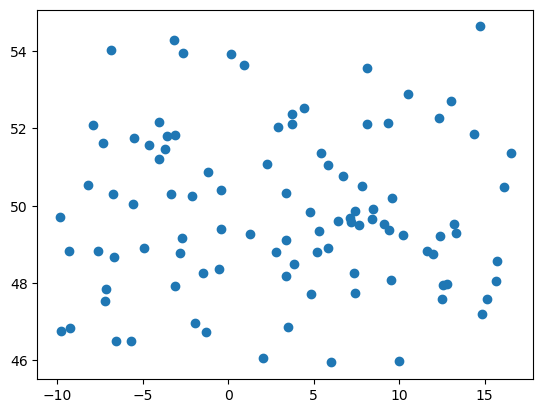

In [18]:
f, ax = plt.subplots()
ax.scatter(
    az.summary(trace_mme, var_names=["a"])["mean"],
    df_data.groupby("patient_id")["tumor_size"].head(1),
)

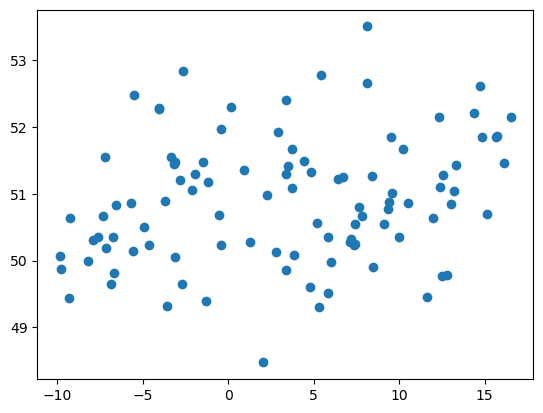

In [19]:
f, ax = plt.subplots()
ax.scatter(
    az.summary(trace_mme, var_names=["a"])["mean"],
    df_data.groupby("patient_id")["tumor_size"].mean(),
)

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu May 09 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

seaborn    : 0.13.2
statsmodels: 0.14.1
scipy      : 1.12.0
matplotlib : 3.8.2
pandas     : 2.2.0
numpy      : 1.25.2

Watermark: 2.4.3

